In [1]:
import torch
import h5py
import numpy as np

from fomo.dataset import DescriptorDatasets
from vae.vae_pl import DescriptorVAE, ModalVAE

import matplotlib.pyplot as plt

In [2]:
test_data = DescriptorDatasets("data/test.h5")

model = DescriptorVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/descriptor/lightning_logs/version_2/checkpoints/epoch=56-step=114000.ckpt",  map_location=torch.device("cpu") , valid_dataset=test_data, latent_dim=8, batch_size=64  )

In [3]:
with h5py.File("data/train.h5", "r") as f:
    print(f.keys())
    bl = f["bl"][:]
    mu_l = f["mu_l"][:]
    mu_s = f["mu_s"][:]
    mu_w = f["mu_w"][:]
    x_s = f["x_s"][:]

<KeysViewHDF5 ['bl', 'log_var_l', 'log_var_s', 'log_var_w', 'mu_l', 'mu_s', 'mu_w', 'r_l', 'r_s', 'r_w', 'x_l', 'x_s', 'x_w', 'z_l']>


In [4]:
index = bl>np.percentile(bl, 90)
mu_l_x = mu_l[index]

In [5]:
np.absolute(mu_l_x.mean(axis=0)-mu_l.mean(0))

array([0.44214764, 0.26179233, 0.59864604, 0.0540448 , 0.06722651,
       0.03947036, 0.24622102, 0.02160774], dtype=float32)

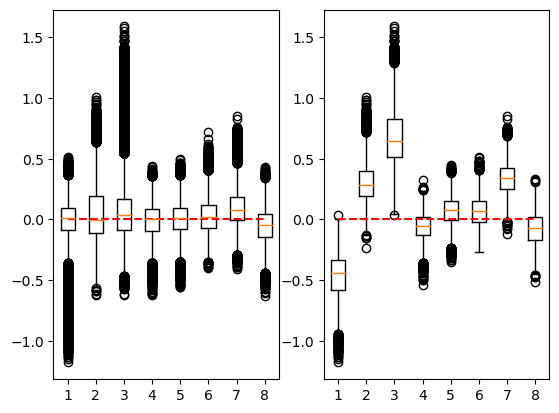

In [18]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(mu_l)
ax[0].hlines(0, 1,8, color = "r", linestyle = "--")

ax[1].boxplot(mu_l_x)
ax[1].hlines(0, 1,8, color = "r", linestyle = "--")

plt.show()


In [6]:
k_list = np.argsort(np.absolute(mu_l_x.mean(axis=0)-mu_l.mean(0)))[::-1]

[64 17 15 18 31 28 25 16 30  9  3 23 10  7  0 21 13 11 14  6 19 42 53  1
 12  8 24 35  4 20 26 60 58 29  5 63 57 46 56 43 61 54  2 36 22 41 33 40
 39 27 59 49 47 55 50 48 32 62 34 52 44 45 51 38 37]
[64  6  9  4  3 17 19  1 16  8 29 21 25 28 20 23  2  7 12 18 24 22 14 50
 31 13 15 11 53 63 40 26  0 52 42 59 27  5 38 57 41 48 60 56 58 62 49 44
 61 33 46 36 10 43 32 30 51 37 34 45 47 39 55 35 54]
[24 28  9  1 22 16 27  6 18 42 13  4 30 63 11 10 15 21 61 31  7 58  2 53
 62 60 36 35 39  5 54 48 56 55 19 33 34 23 38 47 20 43 51 64 41  8 50  3
 57 12 29 40 37 17 25 26 52 32 14 45  0 59 44 49 46]
[10  8 20 27 29 31 15 17  7  3  4 16  1  6  9 25  5 64 53 22 42 12 26 60
 24 50 19 40 57 18 14 59 21 41 35 56 46 11 49 52 38 63  2 28 44  0 30 13
 51 62 36 54 47 43 34 48 61 55 37 45 58 39 32 33 23]


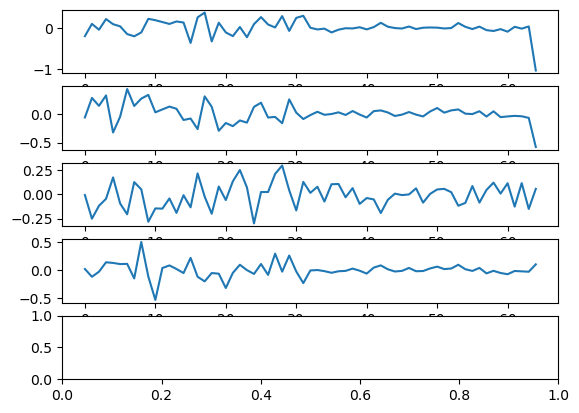

In [19]:
fig, axes = plt.subplots(5,1)
for i, k in enumerate(k_list[:4]):

    latent = mu_l.mean(axis=0)
    latent[k] = mu_l_x.mean(axis=0)[k]
    latent = torch.Tensor(latent[None,:])
    out = model.model.decoder.decode(latent)[0][0,:].cpu().detach().numpy()
    mean_l1 = np.concatenate([mu_w.mean(axis=0), mu_s.mean(axis=0), np.array(bl.mean(axis=0))[np.newaxis]])
    axes[i].plot(mean_l1-out)

    print(np.argsort(np.absolute(mean_l1-out))[::-1])


In [8]:
model_w = ModalVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/grouped_weather/lightning_logs/version_5/checkpoints/epoch=192-step=96500.ckpt", map_location=torch.device("cpu"), inp_shape=(1,36,3), modality="grouped_weather", beta=0.0001, batch_size=16)
model_s = ModalVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/grouped_states/lightning_logs/version_7/checkpoints/epoch=401-step=201000.ckpt", map_location=torch.device("cpu"), inp_shape=(1,104,2), modality="grouped_states", beta=0.0001, batch_size=16)

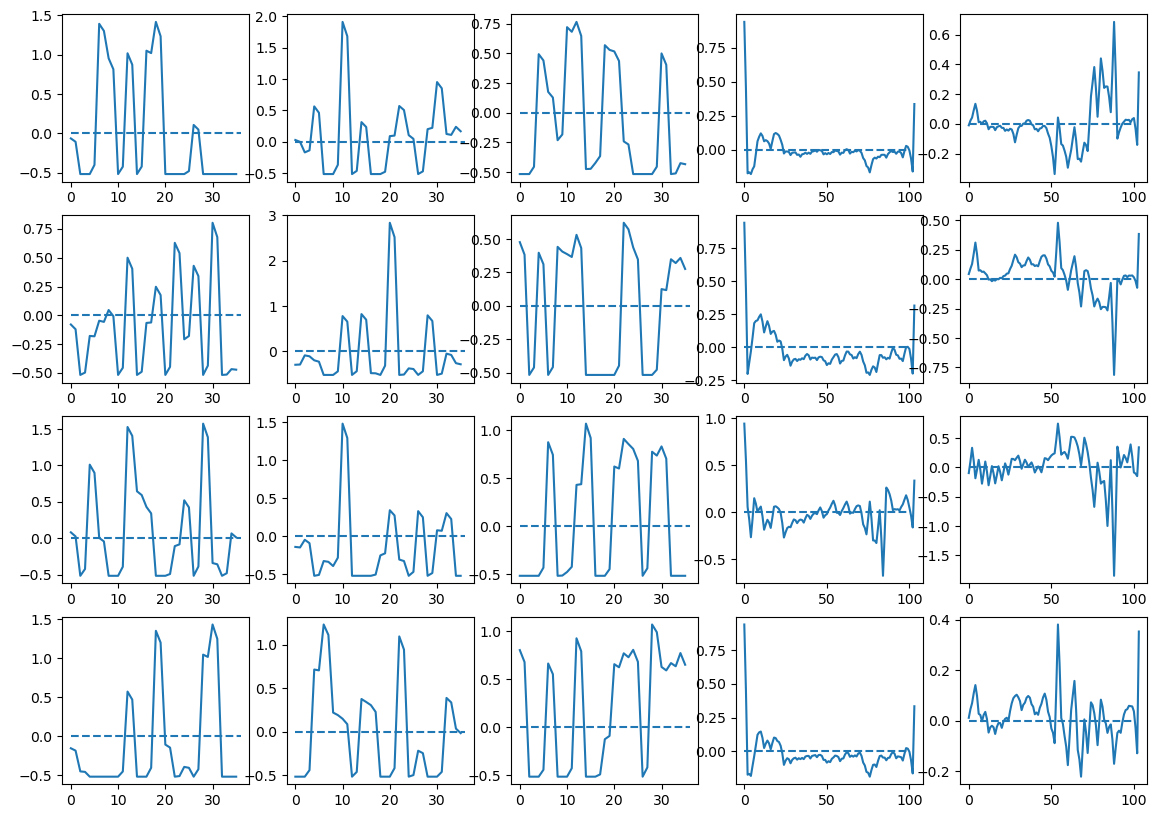

In [21]:
fig, axes = plt.subplots(4,5, figsize=(14,10))
for i, k in enumerate(k_list[:4]):

    latent = mu_l.mean(axis=0)
    latent[k] = mu_l_x.mean(axis=0)[k]
    latent = torch.Tensor(latent[None,:])
    out = model.model.decoder.decode(latent)[0][0,:].cpu().detach().numpy()
    mean_l1 = np.concatenate([mu_w.mean(axis=0), mu_s.mean(axis=0), np.array(bl.mean(axis=0))[np.newaxis]])
    # axes[i].plot(out)
    weather = model_w.model.decoder(torch.Tensor(out[None,:32])).cpu().detach().numpy()[0,0,:,:]
    state = model_s.model.decoder(torch.Tensor(out[None,32:64])).cpu().detach().numpy()[0,0,:,:]

    for j in range(3):
        axes[i,j].plot(weather[:,j])
        axes[i,j].hlines(0, 0,36, linestyle="--")
        
    for l in range(2):
        axes[i,3+l].plot(state[:,l])
        axes[i,3+l].hlines(0, 0,100, linestyle = "--")

